In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


import tf_lab.autopredictors.scripts.virt_scan_data as vscan

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, points_extension, \
                                                 shape_net_core_synth_id_to_category

from tf_lab.autopredictors.scripts import minhyuk_data as minhyuk_loader

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch
    
        
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs, accuracy_of_completion, \
                                           coverage_of_completion, save_reconstructions, \
                                           save_pc_prediction_stats, paper_pc_completion_experiment_id_best_epoch
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

import tf_lab.autopredictors.scripts.iccv as iccv

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [92]:
incomplete_n_samples = 2048
complete_n_samples = 4096
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/paper_vanilla_vscan')

In [ ]:
# print minhyuk_loader.test_categories
# from_manifold = False
# category_id = 3
# min_categ_name = minhyuk_loader.test_categories[category_id]
# minhyuk_data, accuracies = minhyuk_loader.dataset_of_category(category_id, incomplete_n_samples, complete_n_samples, from_manifold)

In [30]:
# l2_norm = np.linalg.norm

# def center_axis(points, axis):
#     res = points.copy()
#     r_max = np.max(res[:, axis])
#     r_min = np.min(res[:, axis])
#     gap = (r_max + r_min) / 2.0    
#     res[:, axis] -= gap
#     return res, gap

# def z_rotation_by_theta(theta):
#     cos_t = np.cos(theta);
#     sin_t = np.sin(theta)
#     R = np.array([[cos_t, -sin_t, 0], 
#                   [sin_t, cos_t, 0],
#                   [0, 0, 1]]
#                 )
#     return R

# minh_full_pc, minh_labels, minh_pc_inc = minhyuk_data.full_epoch_data()
# n_examples = minhyuk_data.num_examples


# if category_id == 0:
#     shrinks = np.zeros(n_examples)
#     shrinkage_multiplier = 3
#     for i in xrange(n_examples):
#         full_centered, gap = center_axis(minh_full_pc[i], 2)
#         minh_full_pc[i] = full_centered
#         minh_pc_inc[i][:,2] = minh_pc_inc[i][:,2] - gap

#         full_centered, gap = center_axis(minh_full_pc[i], 1)
#         minh_full_pc[i] = full_centered
#         minh_pc_inc[i][:,1] = minh_pc_inc[i][:,1] - gap

#         full_centered, gap = center_axis(minh_full_pc[i], 0)
#         minh_full_pc[i] = full_centered
#         minh_pc_inc[i][:,0] = minh_pc_inc[i][:,0] - gap

#         minh_pc_inc[i] = minh_pc_inc[i].dot(z_rotation_by_theta(0))
#         minh_full_pc[i] = minh_full_pc[i].dot(z_rotation_by_theta(0))
        
#         max_dist = np.max(l2_norm(minh_pc_inc[i], axis=1))
#         shrinks[i] = max_dist * shrinkage_multiplier
        
#         minh_pc_inc[i] /= shrinks[i] 
#         minh_full_pc[i] /= shrinks[i]


# if category_id == 2:
#     shrinks = np.zeros(n_examples)
#     shrinkage_multiplier = 2.5
#     for i in xrange(n_examples):
#         full_centered, gap = center_axis(minh_full_pc[i], 2)
#         minh_full_pc[i] = full_centered
#         minh_pc_inc[i][:,2] = minh_pc_inc[i][:,2] - gap

#         full_centered, gap = center_axis(minh_full_pc[i], 1)
#         minh_full_pc[i] = full_centered
#         minh_pc_inc[i][:,1] = minh_pc_inc[i][:,1] - gap

#         full_centered, gap = center_axis(minh_full_pc[i], 0)
#         minh_full_pc[i] = full_centered
#         minh_pc_inc[i][:,0] = minh_pc_inc[i][:,0] - gap

#         minh_pc_inc[i] = minh_pc_inc[i].dot(z_rotation_by_theta(np.pi / 2 * -1.0))
#         minh_full_pc[i] = minh_full_pc[i].dot(z_rotation_by_theta(np.pi / 2 * -1.0))
        
#         max_dist = np.max(l2_norm(minh_pc_inc[i], axis=1))
#         shrinks[i] = max_dist * shrinkage_multiplier
        
#         minh_pc_inc[i] /= shrinks[i] 
#         minh_full_pc[i] /= shrinks[i]


# if category_id == 3:
#     shrinks = np.zeros(n_examples)
#     shrinkage_multiplier = 2.2
#     for i in xrange(n_examples):
#         full_centered, gap = center_axis(minh_full_pc[i], 2)
#         minh_full_pc[i] = full_centered
#         minh_pc_inc[i][:,2] = minh_pc_inc[i][:,2] - gap

#         full_centered, gap = center_axis(minh_full_pc[i], 1)
#         minh_full_pc[i] = full_centered
#         minh_pc_inc[i][:,1] = minh_pc_inc[i][:,1] - gap

#         full_centered, gap = center_axis(minh_full_pc[i], 0)
#         minh_full_pc[i] = full_centered
#         minh_pc_inc[i][:,0] = minh_pc_inc[i][:,0] - gap

#         minh_pc_inc[i] = minh_pc_inc[i].dot(z_rotation_by_theta(np.pi/2*-1.0))
#         minh_full_pc[i] = minh_full_pc[i].dot(z_rotation_by_theta(np.pi/2*-1.0))
        
#         max_dist = np.max(l2_norm(minh_pc_inc[i], axis=1))
#         shrinks[i] = max_dist * shrinkage_multiplier
        
#         minh_pc_inc[i] /= shrinks[i] 
#         minh_full_pc[i] /= shrinks[i]

# if category_id == 4:
#     for i in xrange(n_examples):
#         full_centered, gap = center_axis(minh_full_pc[i], 2)
#         minh_full_pc[i] = full_centered
#         minh_full_pc[i] = minh_full_pc[i].dot(z_rotation_by_theta(np.pi / 2.0))    
#         minh_pc_inc[i][:,2] = minh_pc_inc[i][:,2] - gap
#         minh_pc_inc[i] = minh_pc_inc[i].dot(z_rotation_by_theta(np.pi / 2.0))        


                
# # Optionally keep input with high default-accuracy:
# keep_high_accuracy_only = False
# if keep_high_accuracy_only:
#     mask = np.array(accuracies) >= 0.99
#     minh_full_pc = minh_full_pc[mask]
#     minh_labels = minh_labels[mask]
#     minh_pc_inc = minh_pc_inc[mask]
    
# minhyuk_data_transformed = PointCloudDataSet(minh_full_pc, labels=minh_labels, noise=minh_pc_inc)

In [93]:
GPU = 3
loss = 'chamfer'
class_type = 'all_classes'
# class_type = 'chair'
# class_syn_id = shape_net_category_to_synth_id()[class_type]

In [94]:
experiment_id, best_epoch = paper_pc_completion_experiment_id_best_epoch(class_type, loss)
experiment_name = str(experiment_id) + '_' + class_type + '_' + str(incomplete_n_samples) + '_' \
                  + str(complete_n_samples) + 'pts_' + loss

train_dir = osp.join(train_dir, experiment_name)

In [95]:
conf = Conf.load(osp.join(train_dir, 'configuration'))
conf.consistent_io = None
conf.allow_gpu_growth = True
conf.encoder_args = {'dropout_prob': 1.0}
# print conf
reset_tf_graph()
set_visible_GPUs([GPU])
ae = PointNetAutoEncoder(experiment_name, conf)
ae.restore_model(conf.train_dir, best_epoch, verbose=True)

Model restored in epoch 73.


In [37]:
# # Evaluate Minhyuk
# testing_data = minhyuk_data_transformed
# ae.restore_model(conf.train_dir, best_epoch, verbose=True) 
# top_save_dir = osp.join(conf.train_dir, 'output', 'epoch_' + str(best_epoch))
# save_dir = osp.join(top_save_dir, 'test_predictions')    

# test_recon, test_loss, test_feed, test_ids, test_gt = ae.evaluate(testing_data, conf)

# # Report Accuracy and Coverage of test data.
# n_examples = len(test_recon)
# pred_scores = np.zeros((n_examples, 2))
# for i in xrange(n_examples):    
#     gt = test_gt[i]
#     pred = test_recon[i]    
#     pred_scores[i, 0] = accuracy_of_completion(pred, gt, thres=0.02, ret_dists=False)
#     pred_scores[i, 1] = coverage_of_completion(gt, pred, thres=0.02, ret_dists=False)

# print 'Test Mean-Median Accuracy:', np.mean(pred_scores[:, 0]), np.median(pred_scores[:, 0])
# print 'Test Mean-Median Coverage:', np.mean(pred_scores[:, 1]), np.median(pred_scores[:, 1])

Model restored in epoch 52.
Test Mean-Median Accuracy: 0.644748543546 0.646728515625
Test Mean-Median Coverage: 0.847778739798 0.87255859375


In [38]:
# plt.ioff()
# save_dir = osp.join(top_data_dir, 'OUT', 'cmp_minhyuk', loss, min_categ_name)
# create_dir(save_dir)

# for i in xrange(n_examples):
#     gt = test_gt[i]
#     pred = test_recon[i]
#     feed = test_feed[i]
#     model_name = test_ids[i]
    
#     ac_meas, ac_col = accuracy_of_completion(pred, gt, thres=0.02, ret_dists=True)
#     cov_meas, cov_col = coverage_of_completion(gt, pred, thres=0.02, ret_dists=True)
                    
#     ac_col[ac_col <= 0.02] = 0.021
#     cov_col[cov_col <= 0.02] = 0.021

#     feed_fig = plot_3d_point_cloud_paper(Point_Cloud(points=feed), in_u_sphere=True, show=False);        
#     feed_fig.savefig(osp.join(save_dir,  model_name + '.feed.png')); plt.close()

#     c = ac_col
#     pred_fig = plot_3d_point_cloud_paper(Point_Cloud(points=pred), c=c, in_u_sphere=True, show=False);
#     pred_fig.savefig(osp.join(save_dir, model_name + '.prediction.png')); plt.close()

#     c = cov_col
#     gt_fig = plot_3d_point_cloud_paper(Point_Cloud(points=gt), c=c, in_u_sphere=True, show=False);
#     gt_fig.savefig(osp.join(save_dir, model_name + '.gt.png')); plt.close()

chair001


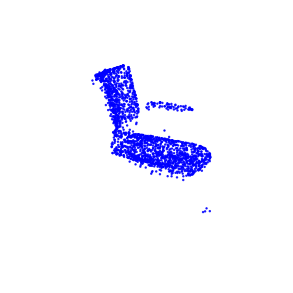

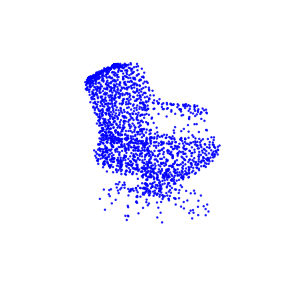

chair002


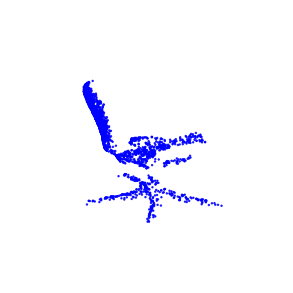

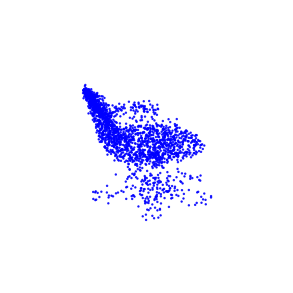

chair003


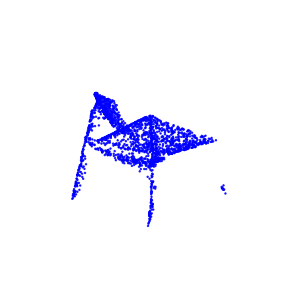

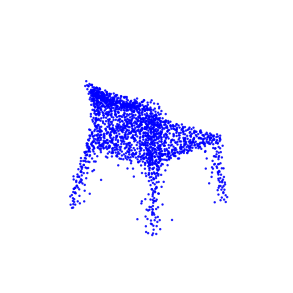

chair006


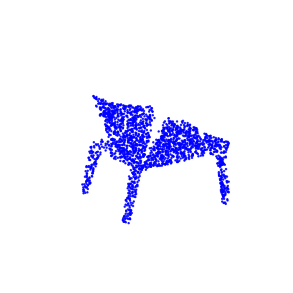

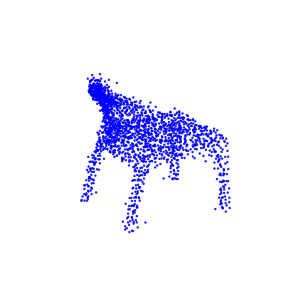

table002


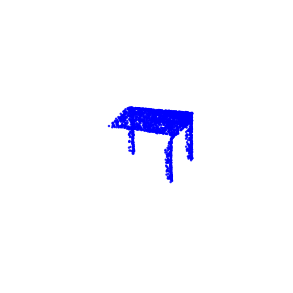

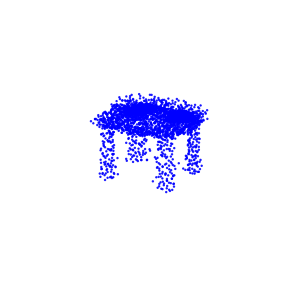

table004


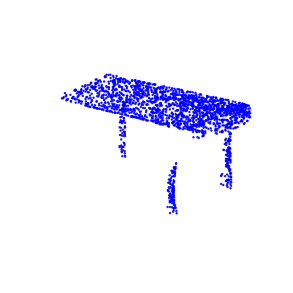

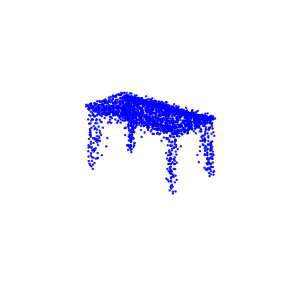

In [129]:
top_kinect_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Minhyuk/kinect_scan_data/'
model_names = ['chair001', 'chair002', 'chair003', 'chair006', 'table002', 'table004']


rotation_angles = np.array([-95, -145, 140, 39, 40, 60])
azimuth_angles = np.array([300, 260, 220, 240, 30, 40])
in_u_s = [False, False, False, False, True, True]
perm = np.array([[0,1,2], [0,1,2], [0,1,2], [0,1,2], [1,0,2], [1,0,2]])

for i, name in enumerate(model_names):
    print name
    file_name = osp.join(top_kinect_dir, name + '_input.ply')
    pc, _ = Point_Cloud(ply_file=file_name).sample(incomplete_n_samples)
    pc.permute_points(perm[i])
    pc.rotate_z_axis_by_degrees(rotation_angles[i])
    pc.center_axis(0)
    pc.center_axis(1)        
    pc.center_axis(2)
    recon = ae.reconstruct(pc.points.reshape(1, incomplete_n_samples, 3), compute_loss=False)[0]
    recon = Point_Cloud(points=np.squeeze(recon))
    iccv.plot_3d_point_cloud(pc, azim=azimuth_angles[i], s=8, in_u_sphere=in_u_s[i])
    iccv.plot_3d_point_cloud(recon, azim=azimuth_angles[i], s=8, in_u_sphere=in_u_s[i])
